## Plot the emittance growth rate vs different values of noise.
- The simulation code is ran 3 times to imporve the accuracy, with different seeds of random numbers where they appear (eg ζ at the white noise kick and the initial particle distributions. 
- The emittance growth is averaged over turns and the variance (standard error) is estimated.

The script is stractured as foolows:
1. Load the data files
2. Plot emittance evolution over turns for different $\Delta$ values, for one run (version)
3. Estimate and plot the losses  
4. Calculate the emittance growth rate, the fit error and the intercept for each set of parameters (Plot rate vs noise strength vs version)
5.  Plot emittance evolution over turns for different $\Delta$ values, for one run (version) along with the fit
6. Find the value of the fitting parameter A that gives the best agreement with the data
7. Plot error vs noise
8. Plot error of the slope vs noise

### test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [1]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import *

### Plotting parameters

In [3]:
params = {'legend.fontsize': 30,
          'figure.figsize': (8.5, 7),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Compute emittance

In [4]:
# #--- <x^2> ---
def mean2(numb):
    return np.mean( (numb - np.mean(numb))**2 )

# #--- <xx'> ---
def mean3(numbx , numbpx):
    return np.mean( (numbx - np.mean(numbx)) * (numbpx - np.mean(numbpx)) )

# #--- sqrt(<x^2> * <px^2> - <xx'>^2) --- compute statistical emittance
def cmp_emit(position, angle):
    return  np.sqrt(mean2(position) * mean2(angle) - mean3(position,angle)**2) # geometrical emittance

### 1. Import the parameters of the study

In [5]:
data = {}
with open('./configuration_files/config_rate_vs_noise.json', "r") as read_file: # The only parameters that you actually use from this file is the beta_x, and the number of turns and particles.
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Loop over delta values and the three versions

In [22]:
Deltas_list = np.geomspace(1e-2,1,5) #the real deltas values, as the ones in the names are shorted
versions = [1, 2, 3]

### Loop over studies. Dictionaries to store the emittance values over turns, 1 dictionay for each version, 1 for each value of delta

In [7]:
ex_dictionary = {}
for version in versions:
    ex_dictionary['v{}'.format(version)] = {}
   
    for Delta in Deltas_list:
        print(version, Delta)
        ex_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)] = []
        if Delta == 1.0:
            df = pd.read_pickle(my_afs_path+'Qx62.775_k3_int5825.61_segments8_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_aperture0.03_v{}.pkl'.format(Delta, version))
        else:
            df = pd.read_pickle(my_afs_path+'Qx62.775_k3_int5825.61_segments8_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_v{}.pkl'.format(Delta, version))

        for turn in range(data['study_parameters']['turns']):
            ex_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)].append(cmp_emit(df.at[turn, 'x']/sqrt(data['machine_parameters']['beta_x']), df.at[turn, 'px']*sqrt(data['machine_parameters']['beta_x'] )))

1 0.01
1 0.03162277660168379
1 0.1
1 0.31622776601683794
1 1.0
2 0.01
2 0.03162277660168379
2 0.1
2 0.31622776601683794
2 1.0
3 0.01
3 0.03162277660168379
3 0.1
3 0.31622776601683794
3 1.0


### 2. Plot emittance evolution over turns for the different values of $\Delta$
- The plot is for one version which specified with the variable "version_test"

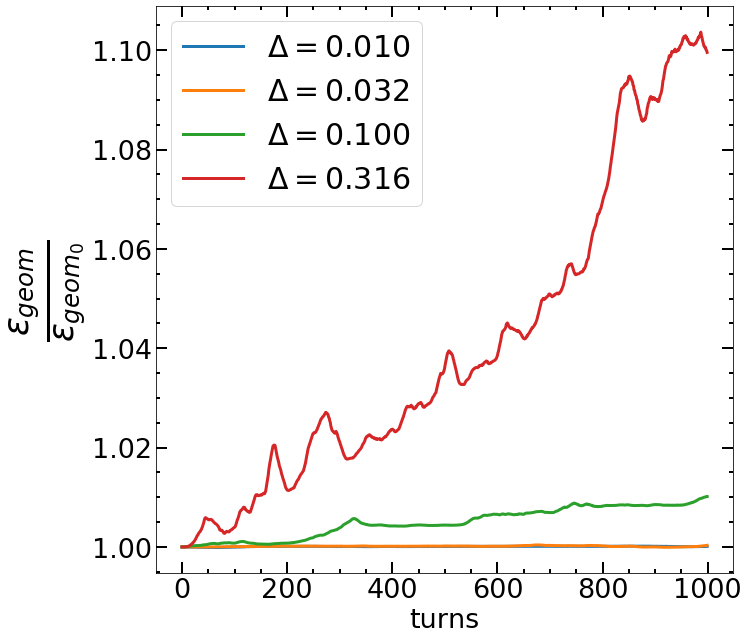

In [25]:
version_test = 1
turns_list = np.arange(0, data['study_parameters']['turns'])

fig, ax = plt.subplots(1,1,figsize=(10.5,9))
for Delta_test in Deltas_list[:-1]: # In the most of the following case Delta is excluded from the analysis as the behavior is not normal
    ax.plot(turns_list, ex_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)]/ex_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)][0], label = r'$\Delta={:.3f}$'.format(Delta_test), linewidth = 3)
ax.set_xlabel('turns')
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}} $', fontsize = 50)

#ax.set_ylim(0, 40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 


# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)



# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
plt.legend()

#plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()




savefig = False
if savefig: 
    plt.savefig('./figures/emittance_evolution_Qx62.775_k3_int5825.61_segments8_g0.200_delta1.000_betax115.75_particles15000_turns1000_aperture3e-2_v{}_ylim.png'.format(version_test))

### 3. Calculate and plot the losses
- Plot the number of particles with value Nan per turn, for one version and one value of Delta, namely Delta_test and version_test

In [26]:
Delta_test = 1.0
version = 1
df_test = pd.read_pickle(my_afs_path+'Qx62.775_k3_int5825.61_segments8_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_aperture0.03_v{}.pkl'.format(Delta_test, version_test))

In [27]:
lost_particles = [] # list with len(turns). Each element is the number of lost particles for the respective turn
for turn in turns_list:
    count_losses = 0 # just a counter to count the losses per turn
    for particle in range(data['study_parameters']['particles']):
        if isnan(df_test.at[turn, 'px'][particle]): # you can jsut check one of the coordinates, the rest will be Nan as well
            count_losses = count_losses + 1
    lost_particles.append(count_losses)

In [ ]:
loss_percentage = np.array(lost_particles)*100/(data['study_parameters']['particles'])

fig, ax = plt.subplots(1,1,figsize=(10.5,9))

ax.plot(turns_list, loss_percentage, label = r'$\Delta={:.3f}$'.format(Delta_test), linewidth = 3)
ax.set_xlabel('turns')
ax.set_ylabel('Losses %')

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 


# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
plt.legend()

#plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()



save_flag = False
if save_flag:
    plt.savefig('./figures/losses_{}.png'.format('Qx62.775_k3_int5825.61_segments8_g0.200_delta1.00_betax115.75_particles15000_turns1000_aperture0.03_v1.png'))

### Find the turn on which all particles are lost

In [ ]:
Delta_test = 1.0
version_test= 1
for turn in turns_list:
    if isnan(ex_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)][turn]):
        print("- Delta {}. All the particles are lost after turn: {}".format(Delta_test,turn))
        break

### 4. Plot rate vs noise strength vs version
- The color code indicate different versions
- Do a linear fit on the emittance values for each value of Delta, to obtain the emittance growth rate.
- The rate for each vale and run/version is also saved for future use

version1, Delta0.01, slope1.2151659412354857e-07, fit_error5.387572629441382e-09
cov [[ 2.90259388e-17 -1.44984564e-14]
 [-1.44984564e-14  9.66080481e-12]]
version1, Delta0.03162277660168379, slope5.6992803525770827e-08, fit_error1.0012365136347477e-08
cov [[ 1.00247456e-16 -5.00736041e-14]
 [-5.00736041e-14  3.33657115e-11]]
version1, Delta0.1, slope1.0078073321516277e-05, fit_error7.650254687178501e-08
cov [[ 5.85263968e-15 -2.92339352e-12]
 [-2.92339352e-12  1.94795455e-09]]
version1, Delta0.31622776601683794, slope0.00010025336677132324, fit_error1.0124846855440944e-06
cov [[ 1.02512524e-12 -5.12050057e-10]
 [-5.12050057e-10  3.41196021e-07]]
version2, Delta0.01, slope2.9120701867296726e-07, fit_error5.7348385702226556e-09
cov [[ 3.28883734e-17 -1.64277425e-14]
 [-1.64277425e-14  1.09463524e-11]]
version2, Delta0.03162277660168379, slope3.0861325409943326e-07, fit_error1.095602556396421e-08
cov [[ 1.20034496e-16 -5.99572308e-14]
 [-5.99572308e-14  3.99515015e-11]]
version2, Delta0.

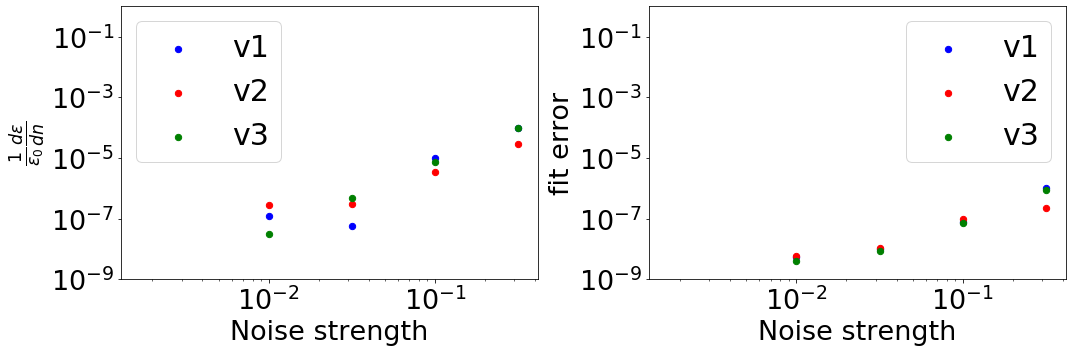

In [9]:
# Do not include the Delta =1  to the plot, cause the error is to big. The emittance growth is clearly not linear
Deltas_list = Deltas_list[:-1]

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
turns_list = np.arange(0, data['study_parameters']['turns'])

colors = ['b', 'r', 'g']
color_pointer = 0

rate_dictionary = {} # this dicitonary stores the emittance growth rate for every noise (Delta) value for each one of the different runs (versions)
intercept_dictionary = {}
fit_error_dictionary= {} # this dicitonary stores the error on the slope of the fit (uncertainty of linear regression) for every noise (Delta) value for each one of the different runs (versions)

for version in versions:
    rate_dictionary['v{}'.format(version)] = {}
    fit_error_dictionary['v{}'.format(version)] = {}
    intercept_dictionary['v{}'.format(version)] = {}
    for Delta in Deltas_list:
        rate_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)] = []
        intercept_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)] =[]
        fit_error_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)] = []

for version in versions:
    for index, Delta in enumerate(Deltas_list):
        current_study =  ex_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)][0:]
        # Do the linear fit
        [m_h,b_h], cov_h = np.polyfit(turns_list[0:], current_study/current_study[0], 1, cov= True)
        err_h = np.sqrt(np.diag(cov_h))
        print("version{}, Delta{}, slope{}, fit_error{}".format(version, Delta, m_h, err_h[0]))
        print('cov', cov_h)
        rate_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)].append(m_h)
        intercept_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)].append(b_h)
        fit_error_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)].append(err_h[0])
        
        if index == 0:
            ax.scatter(Delta, m_h, s=40, c = colors[color_pointer], label = 'v{}'.format(version))
            ax2.scatter(Delta,err_h[0], s=40, c = colors[color_pointer], label = 'v{}'.format(version) )
        else:
            ax.scatter(Delta, m_h, s=40, c = colors[color_pointer])
            ax2.scatter(Delta, err_h[0], s=40, c = colors[color_pointer])
    color_pointer = color_pointer+1
ax.legend()
ax.set_ylim(10e-10, 10e-1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Noise strength')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)

ax2.set_ylim(10e-10, 10e-1)
ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Noise strength')
ax2.set_ylabel('fit error')
plt.tight_layout()

### 5. Plot evolution of the emittance with the fit

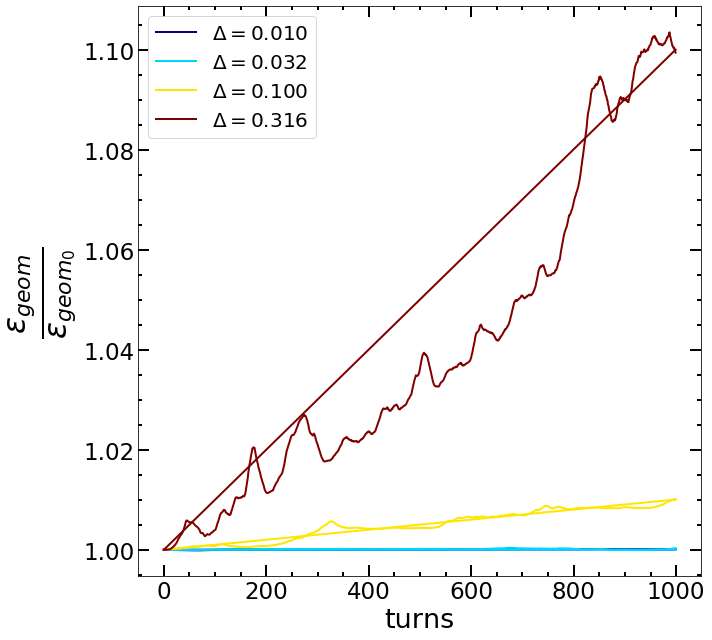

In [10]:
jet = plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,len(Deltas_list))))

version_test = 1
turns_list = np.arange(0, data['study_parameters']['turns'])
fig, ax = plt.subplots(1,1,figsize=(10,9))

for Delta_test in Deltas_list:
    #fig, ax = plt.subplots() # if you want one combined plot, comment out this line
    c1 = next(colors)
    slope = rate_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)]*turns_list

    ax.plot(turns_list, ex_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)]/ex_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)][0], label = r'$\Delta={:.3f}$'.format(Delta_test), c = c1, linewidth=2)
    ax.plot(turns_list, slope+1., c =c1, linewidth=2)# intercept_dictionary['v{}'.format(version_test)]['Delta{}'.format(Delta_test)], c = c1)
    
    
    # if you want one combined plot move the lines below out of the loop
ax.set_xlabel('turns')
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}} $', fontsize = 45)


# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 


# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)



# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
plt.legend()

#plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

savefig = False
if savefig: 
    plt.savefig('./figures/emittance_evolution_fit_Qx62.78__k3_int5825.61_segments8_g0.200_delta{:.3f}_betax115.75_particles15000_turns1000_v{}.png'.format(Delta_test, version_test))#.format(Delta_test))

### 6. Find which value of the fitting parameter A gives the best agreement with the simulation data
by doing a linear fit on the values of the emittance growth rate over the different values of $\Delta$
Recall that :
\begin{equation}
\frac{d\epsilon}{dn} = A \frac{\xi^2 \Delta^2}{2g^2} \epsilon_{geom_0}
\end{equation}


Therefore the slope of the linear fit, $m_h$, is equal to 
\begin{equation}
m_h = A \frac{\xi^2 }{2g^2} 
\end{equation}

, which means that 
\begin{equation}
A =  m_h \frac{2g^2}{\xi^2} 
\end{equation}
, where $\xi$ the induced tune spread by the octupole

[ 7.77177064e-04 -8.44925661e-06 -5.88007174e-09]
the fitting parameter A is estimated :2.4869666057648736


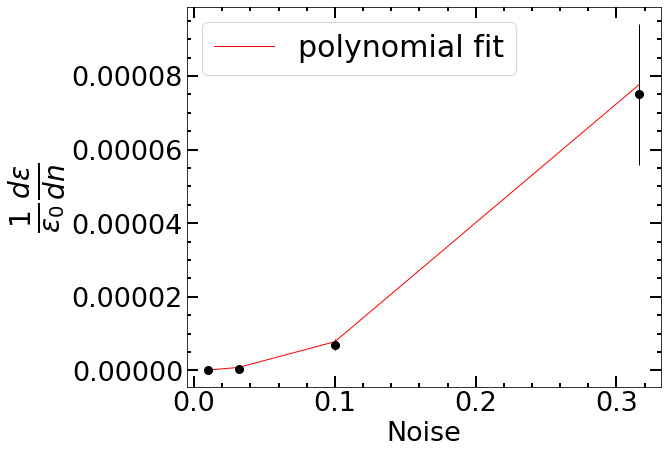

In [13]:
fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

average_rate_list = []

# Prameters of the study, that are required for the calculation of the fitting parameter A
ksi = 0.005 #the tune spread caused by the octupole
g = 0.2

for index, Delta in enumerate(Deltas_list):
    current_version_rate = [] # the rate for this study, you need to store them in a list to calculate the average and the standard deviation
    for version in versions:
           current_version_rate.append(rate_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)][0])
    # Calculate average and variance
    average_rate = np.mean(current_version_rate)
    average_rate_list.append(average_rate)
    standard_error = np.std(current_version_rate)/sqrt(len(versions))
    
    #ax.scatter(Deltas_list_real[index], average_rate , s=40, c = 'r')
    ax.errorbar(Delta, average_rate, yerr=standard_error, c='k', marker ='o', ms =8)
    
 
m_h = np.polyfit(Deltas_list, average_rate_list, 2) # deg = 2, the degree of the fitting polynomial is 2
print(m_h)
A = m_h[0] *2 *g**2 / ksi**2
print('the fitting parameter A is estimated :{}'.format(A))


ax.plot(Deltas_list, m_h[0]*Deltas_list**2, c = 'r', label='polynomial fit')


# Plotting parameters
ax.set_xlabel('Noise')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')

plt.legend(loc=2)

### 7. Plot rate vs noise + error bars
- each point is the average of three different runs (aka versions)
- the error bars correspond to the standard error between the three different runs
- The user needs to provide the values of the tune shift caused by the octupole (ie ksi, to be in accordance with the case when the BB kick is used) and g that correspond to the specific study

6.20453706338778e-08
9.660871864863415e-08
1.5467655366925785e-06
1.9105669813811174e-05
theory rate [7.771770643015228e-08, 7.771770643015226e-07, 7.77177064301523e-06, 7.771770643015228e-05]


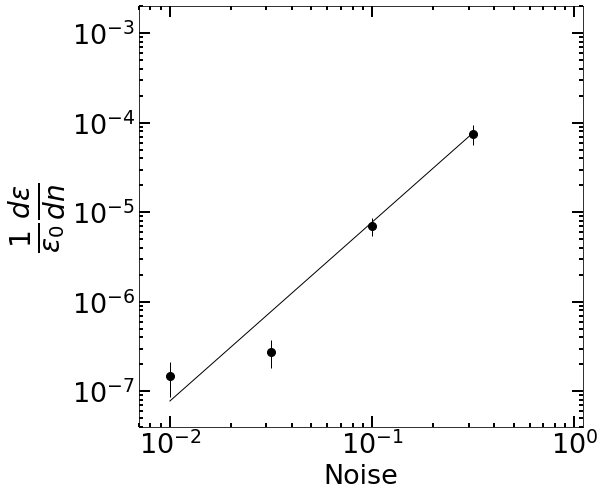

In [14]:
# Prameters of the study, that are required for the calculation of the fitting parameter A
ksi = 0.005 #the tune spread caused by the octupole
g = 0.2


fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

theory_rate = []

for index, Delta in enumerate(Deltas_list):
    current_version_rate = [] # the rate for this study, you need to store them in a list to calculate the average and the standard deviation
    for version in versions:
           current_version_rate.append(rate_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)][0])
    # Calculate average and variance
    average_rate = np.mean(current_version_rate)
    standard_error = np.std(current_version_rate)/sqrt(len(versions))
    print(standard_error)
    
    #ax.scatter(Deltas_list_real[index], average_rate , s=40, c = 'r')
    ax.errorbar(Delta, average_rate, yerr=standard_error, c='k', marker ='o', ms =8)
    
    
    theory_rate.append(A*((ksi**2)*((Delta**2))/(2*g**2)))

# Plot theoretical rate
ax.plot(Deltas_list, theory_rate, c = 'k') 
print('theory rate', theory_rate)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Noise')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')

ax.set_xlim(7e-3, 1+1e-1)    
ax.set_ylim(4e-8, 2e-3)

savefig = False
plt.tight_layout()
if savefig: 
    plt.savefig('./figures/rate_vs_noise_Qx62.78_k3_int5825.61_g0.200_deltaScan_betax115.75_particles15000_turns1000_A{}.png'.format(A))    

### 8. Plot error fit vs noise  + error bars
- each values is the average of the three different runs (versions)
- add error bars, standard error $\sigma_x$ between the three different runs (versions)

\begin{equation}
\sigma_x = \frac{\sigma}{\sqrt{n}}
\end{equation}
, where $\sigma$ is the standard deviation of the population and $n$ the number of observations of the sample

4.349584391589921e-10
5.020886204098194e-10
6.37445156562977e-09
1.997515178926823e-07


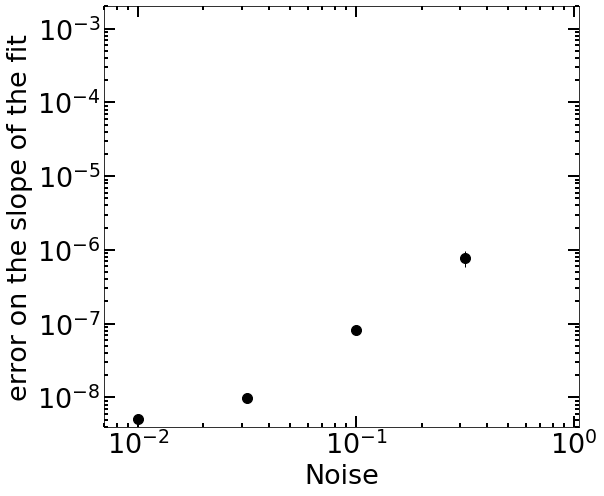

In [15]:
fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

for index, Delta in enumerate(Deltas_list):
    current_version_error= [] # the rate for this study, you need to store them in a list to calculate the average and the standard deviation
    for version in versions:
           current_version_error.append(fit_error_dictionary['v{}'.format(version)]['Delta{}'.format(Delta)][0])
    # Calculate average and variance, between the three different runs
    average_error = np.sqrt(np.mean(np.array(current_version_error)**2)) # error propagation
    standard_error = np.std(current_version_error)/sqrt(len(versions)) # standard error between the three different runs
    print(standard_error)
    
    #ax.scatter(Deltas_list_real[index], average_rate , s=40, c = 'r')
    ax.errorbar(Delta, average_error, yerr=standard_error, c='k', marker ='o', ms =10)

    
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Noise')
ax.set_ylabel('error on the slope of the fit')

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
    
ax.set_xlim(7e-3, 1.05)    
ax.set_ylim(4e-9, 2e-3)

savefig = False
plt.tight_layout()
if savefig:
    plt.savefig('./figures/fit_error_vs_noise_Qx62.775__k3_int5825.61_segments8_g0.200_deltaScan_betax115.75_particles15000_turns1000_ylimON.png')